# Pull Data

Grabbing WebIDs ...
WebID collection complete!
12:47:16: Sending API request... Chunk 1 of 1
12:47:17: Response recieved for 1 tags! (1.41)
Grabbing WebIDs ...
WebID collection complete!
12:47:18: Sending API request... Chunk 1 of 1
12:47:19: Response recieved for 1 tags! (1.51)


Text(0, 0.5, 'Electricity')

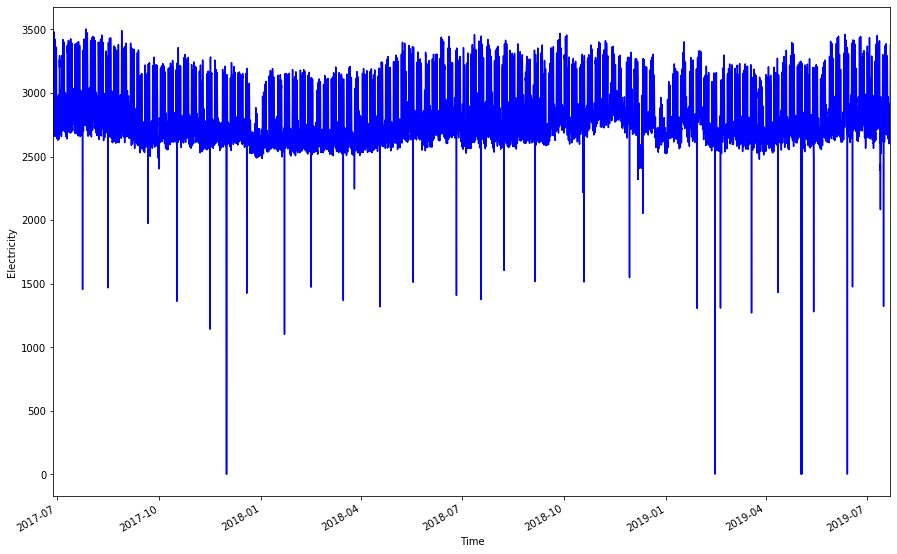

In [2]:
import sys
"""Put the path to the eco-tools folder in the following line... should look something like this one below"""
sys.path.append(r"C:\\Users\\ejgoldbe\\Desktop\\eco-tools/") #path to PI CLient
#if not working: pip install requests-kerberos Desktop
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from ecotools.pi_client import pi_client
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from dateutil.relativedelta import relativedelta
from matplotlib.lines import Line2D


pc = pi_client(root='readonly')
points = pc.search_by_point("GBSF_Electricity_Demand_kBtu")
second_points = pc.search_by_point('aitit4045*')
start = "06-28-2017"
end = "*"
interval = '1h' #can be 1d 2d for days or 1s for seconds or 1m for minutes
calculation = 'summary'
df = pc.get_stream_by_point(points, start = start, 
                            end = end, calculation=calculation,
                            interval=interval)
df2 = pc.get_stream_by_point(second_points, start = start, end = end, calculation=calculation, interval=interval)
series = pd.Series(df.iloc[:, 0], index = df.index)
plt.figure(figsize = (15, 10))
series.replace(np.nan, 0, inplace=True)
series.plot(kind = 'line', color = 'blue')
plt.xlabel("Time")
plt.ylabel("Electricity")

# Isolation Forest


Threshold: -0.0981372666612208
[ 0.07187763  0.07270967  0.07270967  0.07709438  0.06769839  0.07499034
  0.05722459  0.02330441  0.00723492  0.02317733 -0.0239907  -0.09508814
 -0.10697767 -0.17263363 -0.17172406 -0.16494134 -0.10539076 -0.05270915
 -0.01645399  0.01484326]


Text(0.5, 1.0, 'Data Without Outliers')

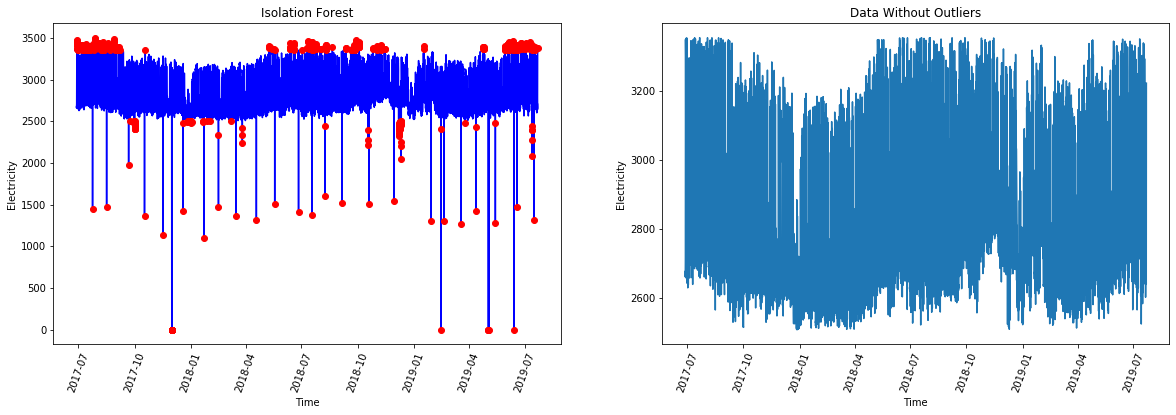

In [3]:
from sklearn.ensemble import IsolationForest
from scipy import stats

X = np.array(series.values).reshape(-1, 1)
model = IsolationForest().fit(X)
scores_pred = model.decision_function(X)
threshold = stats.scoreatpercentile(scores_pred, 100 * 0.03)
#print the threshold
print("Threshold:", threshold)
all_indexes = list(range(len(series)))
outlier_indexes = [i for i in all_indexes if scores_pred[i] < threshold]
plt.figure(figsize = (20, 13))
print(scores_pred[0:20])
plt.subplot(2, 2, 1)
plt.plot(series.index, series.values, color= "blue")
#plot outliers
for index in outlier_indexes:
    outlier_point = series.values.tolist()[index]
    date_index = series.index[index]
    plt.plot(date_index, outlier_point, color = 'red', marker = 'o')
plt.xlabel("Time")
plt.ylabel("Electricity")
plt.title("Isolation Forest")
plt.xticks(rotation = 70)
plt.subplot(2, 2, 2)
#extract data without outliers
non_outlier_indexes = [i for i in all_indexes if i not in outlier_indexes]
non_outlier_dates = [series.index[j] for j in non_outlier_indexes]
non_outlier_data = [series.values.tolist()[i] for i in non_outlier_indexes]
non_outlier_series = pd.Series(non_outlier_data, index = non_outlier_dates)
plt.plot(non_outlier_series.index, non_outlier_series.values)
plt.xticks(rotation=70)
plt.xlabel("Time")
plt.ylabel("Electricity")
plt.title("Data Without Outliers")



# Linear Regression Method

Text(0.5, 1.0, 'Data Without Outliers')

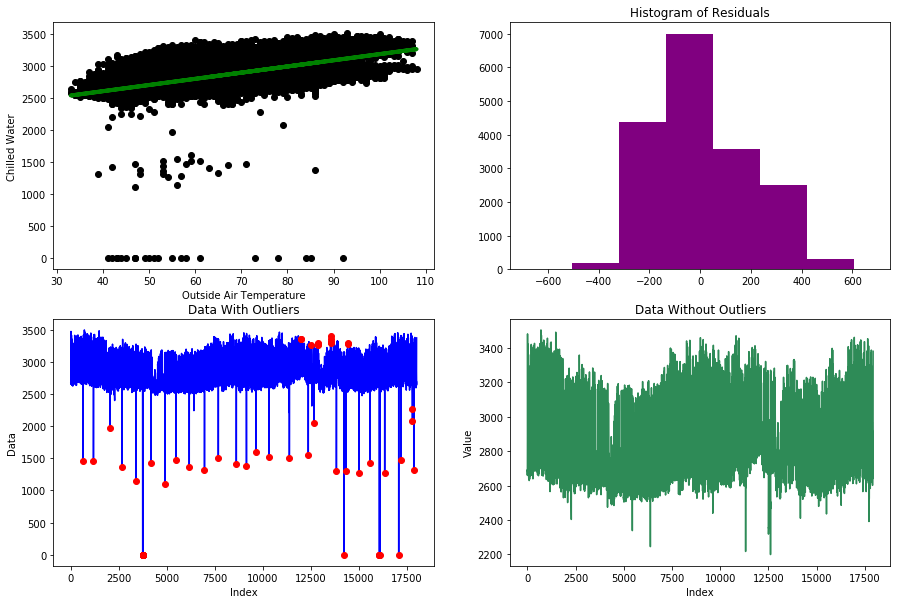

In [4]:
from sklearn.linear_model import LinearRegression

#pull data - df is electricity, df2 is outside air temperatue
new_df = pd.merge_asof(df, df2, on = "Timestamp")
#drop any NA values
new_df = new_df.dropna()

#round columns
for col in new_df.columns[1:3]:
    new_df[col] = new_df[col].apply(lambda x: round(x, 0))
#reshape the data so you can use it in the linear reg. model
#here is where you would apply x^2
x =  np.array(new_df.iloc[:, 2]).reshape(-1, 1)
y = np.array(new_df.iloc[:, 1]).reshape(-1, 1)
lnn = LinearRegression().fit(x, y)
#the linear model's fitted predictions
preds = lnn.intercept_ + lnn.coef_ * x
plt.figure(figsize = (15, 10))
plt.subplot(2, 2, 1)
#the residuals: actual electricity - predicted
residuals = (y - preds).reshape(-1, 1)
upper_bound = np.mean(residuals) + 2.5*np.std(residuals)
lower_bound = np.mean(residuals) - 2.5*np.std(residuals)
indexes = []
for i in range(len(residuals)):
    residual = residuals[i]
    if residual > upper_bound or residual < lower_bound:
        indexes.append(i)
y = np.ravel(y).tolist()
outliers = [y[i] for i in indexes]
plt.scatter(x, y, color = "black")
plt.plot(x, preds, color = "green", linewidth=4)
plt.xlabel("Outside Air Temperature")
plt.ylabel("Chilled Water")
plt.subplot(2, 2, 2)
#plot residuals
plt.hist(residuals, color = "purple", bins = 20)
plt.xlim([-750, 750])
plt.title("Histogram of Residuals")
plt.subplot(2, 2, 3)
plt.plot(y, color = "blue")
for i in indexes:
    outlier = y[i]
    plt.plot(i, outlier, color = "red", marker = "o")
plt.xlabel("Index")
plt.ylabel("Data")
plt.title("Data With Outliers")
#retrieve data without outliers
non_outlier_indexes = [i for i in range(len(y)) if i not in indexes]
new_data = [y[i] for i in non_outlier_indexes]
plt.subplot(2, 2, 4)
plt.plot(new_data, color = "seagreen")
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Data Without Outliers")



# Quantile Method

,ninety_ninth,first
0,3387.891755,2511.300873


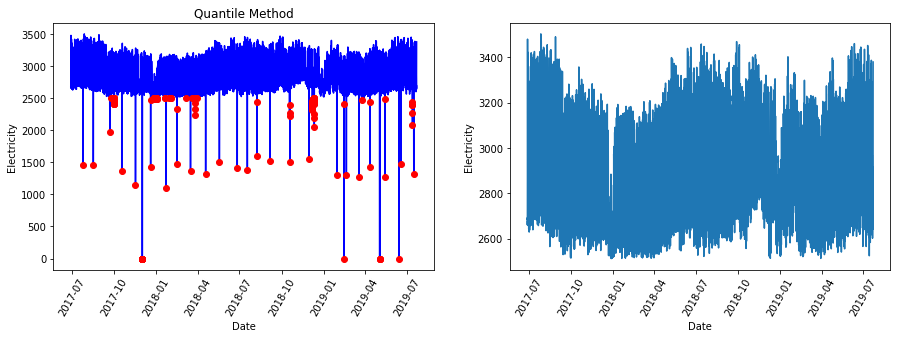

In [7]:
#this method works for 1d data, which is what we have
#simply trim the top X percent off the bottom of the time series and flag these as outliers
#get the trimmed series values
from scipy.stats import tmean, scoreatpercentile
#retrieve electricity as a Series
X = df.iloc[:, 0]
upper_bound = X.quantile(0.99)
lower_bound = X.quantile(0.01)
outliers = []
plt.figure(figsize = (15, 10))
plt.subplot(2, 2, 1)
plt.plot(series.index, series.values, color = "blue")
outlier_indexes = []
for i in range(len(series.values)):
    value = series.values[i]
    if value < lower_bound:
        outlier_indexes.append(i)
        date = series.index[i]
        plt.plot(date, value, color = "red", marker = "o")
plt.title("Quantile Method")
plt.xlabel("Date")
plt.xticks(rotation=60)
plt.ylabel("Electricity")
plt.subplot(2, 2, 2)
non_outlier_indexes = [i for i in range(len(X)) if i not in outlier_indexes]
non_outlier_data = [X.values.tolist()[i] for i in non_outlier_indexes]
non_outlier_dates = [X.index[i] for i in non_outlier_indexes]
plt.plot(non_outlier_dates, non_outlier_data)
plt.xticks(rotation=60)
plt.xlabel("Date")
plt.ylabel("Electricity")

info_df = pd.DataFrame(dict(ninety_ninth = upper_bound, first = lower_bound), index = [0])
info_df
        
        
        